<a href="https://colab.research.google.com/github/stupidbutsmart/DELE-CA1/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
  b {
    color: red;
  }
</style>

## Section A CA1 CNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [ ]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Conv2D, MaxPooling2D , UpSampling2D, Cropping2D, ReLU, BatchNormalization, Dropout
from sklearn.model_selection import RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import IsolationForest
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

## for keras classifier i will be using scikeras lib
## 2.12+ no longer supports tensorflow.keras.wrappers.scikit_learn
## this was coded in across different versions (namely 2.10 and 2.19)
from scikeras.wrappers import KerasClassifier


tf.random.set_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

### Creating UDFs to aid workflow

Before i start, i want to create some functions that can help me with my work.

basic functions like:
1. create model function
2. autoencoder function
3. data processing functions

etc.

This can help modularize my code (especially since im working with 2 models) and make it easier for future collaborater to understand

In [2]:
DATASET_PATH = './datasets/'

def get_greyscale_data(data_type , size):
  targets = [ target for target in os.listdir(DATASET_PATH + data_type)]

  rows = []
  for target in targets: 
    for file_name in os.listdir(os.path.join(DATASET_PATH , data_type ,  target)):
      # greyscale 
      img = image.load_img(os.path.join(DATASET_PATH , data_type, target , file_name ) ,color_mode='grayscale' , target_size=size)
      img = image.img_to_array(img) / 255.0 # divide by 255 to normalize it
      
      record = {'sequence' : img}
      for t in targets:
        record[t] = 1 if t == target else 0

      rows.append(record)

  return pd.DataFrame(rows , columns=['sequence'] + targets)



In [3]:
STORED_DATA = './stored_data/'
def build_raw_data(size):
  """ size should be a single number n for n x n pixels
  """
  res = []
  for file in os.listdir(STORED_DATA):
    if file.endswith('23.json') and (str (size) in file):
      res.append(pd.read_json(os.path.join(STORED_DATA , file)))
  return res

### Data Cleaning and Exploration

I plan to do manual inspection to clean my data, therfore cleaning will be done before importing

##### What i Found

1. There are some **duplicated images**, we will remove using **.drop_duplicates()** when we eventually import it

##### Test:

1. **Pumpkin** Folder Contains only **Tomatoes**
2. **Tomato** Folder Contains only **Pumpkins**

So i just changed the names of those folders

##### Train:

1. **Beans** Contains some **Carrots**

I will move them into the **carrots** folder, incase of duplicates, they will be dropped later.

##### Validation:

Looks about as clean as it can get

In [4]:
## NOTE
## get_greyscale_data() takes awhile to run
## below there is a function that builds the DF from ./stored_data
## run if ./stored_data was not provided, otherwise run cell with build_data() below
train_data = get_greyscale_data('train' , (23 , 23))

KeyboardInterrupt: 

In [6]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[0.7294118], [0.7294118], [0.7372549], [0.73...",1,0,0,0,0,0,0,0,0,0,0
1,"[[[0.7294118], [0.7294118], [0.7372549], [0.73...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[0.33333334], [0.49803922], [0.5019608], [0....",1,0,0,0,0,0,0,0,0,0,0
3,"[[[0.33333334], [0.49803922], [0.5019608], [0....",1,0,0,0,0,0,0,0,0,0,0
4,"[[[0.85882354], [0.8666667], [0.8784314], [0.8...",1,0,0,0,0,0,0,0,0,0,0


In [72]:
## repeat for test and validation
test_data = get_greyscale_data('test' , (23 , 23))
validation_data = get_greyscale_data('validation' , (23 , 23))


In [12]:
# Removing Duplicates
def remove_dupes(data):
  # Since we cannot hash lists, we need a string equivalent
  # This allows me to use the drop_duplicate function
  data['sequence_str'] = data['sequence'].apply(lambda x: str(x))
  data = data.drop_duplicates(subset=[col for col in data.columns if col != 'sequence'])
  data = data.drop(columns=['sequence_str'])
  return data

test_data = remove_dupes(test_data)
train_data = remove_dupes(train_data)
validation_data = remove_dupes(validation_data)

In [13]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[0.7294117808], [0.7294117808], [0.737254917...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[0.33333334330000003], [0.49803921580000005]...",1,0,0,0,0,0,0,0,0,0,0
4,"[[[0.8588235378], [0.8666666746], [0.878431379...",1,0,0,0,0,0,0,0,0,0,0
6,"[[[0.6980392337], [0.7058823705], [0.709803938...",1,0,0,0,0,0,0,0,0,0,0
8,"[[[0.6784313917], [0.6745098233], [0.674509823...",1,0,0,0,0,0,0,0,0,0,0


In order to save computional time, we will save the data, allowing us to build our df from it.

We are using json format, as integrates seamlessly with my **sequence** column

In [14]:
train_data.to_json(os.path.join(STORED_DATA , 'train_23.json') , orient='records')
test_data.to_json(os.path.join(STORED_DATA , 'test_23.json') , orient='records')
validation_data.to_json(os.path.join(STORED_DATA , 'validation_23.json') , orient='records')

With our data exported, we can reimport it 

In [5]:
test_data , train_data , validation_data = build_raw_data(23)

We can recontruct it and plot it using matplotlib 

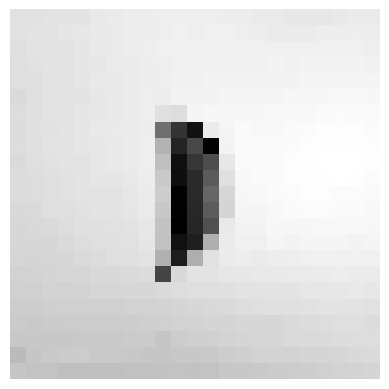

In [6]:
plt.imshow(train_data['sequence'].iloc[0] , cmap='gray')
plt.axis('off')
plt.show()

##### Comparing it to its real img counterpart
<style>
.two_col_row {
  display: grid;
  grid-template-columns: 1fr 1fr; /* Two equal columns */
  gap: 20px; /* Space between items */
  padding: 20px
}

img {
  height: auto;
  width: 100%;
}



  </style>
<div class='two_col_row'>
  <img src='./markdown/bean_1_imap.png'>
  <img src='./markdown/bean_1_original.jpg'>
</div>


looks like a very nice bean

##### Creating Model

The Idea behind my model is going to be as follows:

1. Input Layer
2. Conv2d * **n** amounts
3. BatchNormalize
4. Activation Relu
5. Maxpooling/bottleneck layer
6. Flatten
7. Dense - softmax (we are doing multiclass-classification)

where layers 2-5 can be repeated **m** times.

For the grid Search, since i already have dedicated validation data, i will not be using kfold-cv.

In [7]:
def create_model(n , m, max_neurons , 
            dropout, kernel_size, strides, padding, activation,
            bottleneck
                 ):
  model = Sequential()

  # we want the neurons to be increasing, getting more complex further in
  neurons_arr = [32] # starting
  for _ in range(m -1 ):
    neurons_arr.append(min(neurons_arr[len(neurons_arr) - 1] * 2 ,  max_neurons))
  
  for i in range(m):
    # Adding n number of conv2d
    for ii in range(n):
      model.add(Conv2D(neurons_arr[i], kernel_size, strides=strides, padding=padding))

    model.add(BatchNormalization())
    model.add(activation)
    model.add(bottleneck)
  
  model.add(Dropout(dropout))
  model.add(Flatten())
  model.add(Dense(11 , activation='softmax'))
  model.compile(loss='categorical_crossentropy' , optimizer='adam' , metrics=['accuracy'])
  return model
 
  


In [8]:
X_train = np.stack(train_data['sequence'])
y_train = train_data.drop(columns=['sequence']).values.astype(float)

X_test = np.stack(test_data['sequence'])
y_test = test_data.drop(columns=['sequence']).values

X_validation = np.stack(validation_data['sequence'])
y_validation = validation_data.drop(columns=['sequence']).values.astype(float)

In [9]:
hyper_params = { 
  'n': np.arange(1 , 4),
  'm': np.arange(1 , 3),
  'max_neurons':  [32 , 64 , 128 , 256],
  'dropout': np.arange(0.1 , 0.4 , 0.1),
  'strides': [(1 , 1)],
  'padding': ['valid' , 'same'],
  'activation': [ReLU()],
  'bottleneck': [MaxPooling2D()],
  'kernel_size': [(3 , 3) , (5 , 5)]
}

val_losses = []
val_accuracies = []
fit_results = []
successful_params = []


In [10]:

# Grid Search
for params in list(ParameterGrid(hyper_params)):
  try:
    print(f'Tuning for {params}... ')

    # Create and fit
    model = create_model(**params)
    early_stop = EarlyStopping(monitor='val_loss' , patience=5 , restore_best_weights=True)
    fit_result = model.fit(X_train, y_train, epochs=100 , 
              batch_size=16, 
              validation_data=(X_validation , y_validation) 
              , callbacks=[early_stop]
              ,verbose = 0
              )

    # Eval and store 
    # will not be using cross val score since we have dedicated vaildation data.
    val_loss , val_accuracy = model.evaluate(X_validation , y_validation)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    fit_results.append(fit_result.history)
    successful_params.append(params) # this is required since im skipping bad params

    print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}')
  except Exception as error:
    # handles any bad params configurations
    print('Error occured with this param configuration')
    continue

Tuning for {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D45A990F40>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D47412BDF0>, 'dropout': 0.1, 'kernel_size': (3, 3), 'm': 1, 'max_neurons': 32, 'n': 1, 'padding': 'valid', 'strides': (1, 1)}... 


KeyboardInterrupt: 

In [ ]:
# Exporting 
results = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'fit_results': fit_results
})

with open(os.path.join('stored_models' , '23_tuning_results_v2.pkl') , 'wb') as f:
  pickle.dump(results, f)
                       

In [13]:
# Importing the results
results = None

with open(os.path.join('stored_models' , '23_tuning_results_v2.pkl') , 'rb') as f:
  results = pickle.load(f)

# Deconstructing Results

val_accuracies = results['validation_accuracies']
val_losses = results['validation_losses']
successful_params = results['params']
fit_results = results['fit_results']
                   

##### Best Model Analysis

In [14]:
# Getting best the set of parameters
best_index = np.argmax(val_accuracies)
best_params = successful_params[best_index]
best_acc = val_accuracies[best_index]
best_loss = val_losses[best_index]
                                 
print(f'Best Params: {best_params}')
print(f'Best acc: {best_acc}')
print(f'Best loss: {best_loss}')

Best Params: {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.30000000000000004, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 128, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
Best acc: 0.7331818342208862
Best loss: 0.9876277446746826


Here i want to consider the top 5, since i plan to tune the amount of data feeded into the NN

There is chance that 'worse performing' models may perform better with specific amounts of data


For now i want to look at the loss and learning rates

{'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.30000000000000004, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 128, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


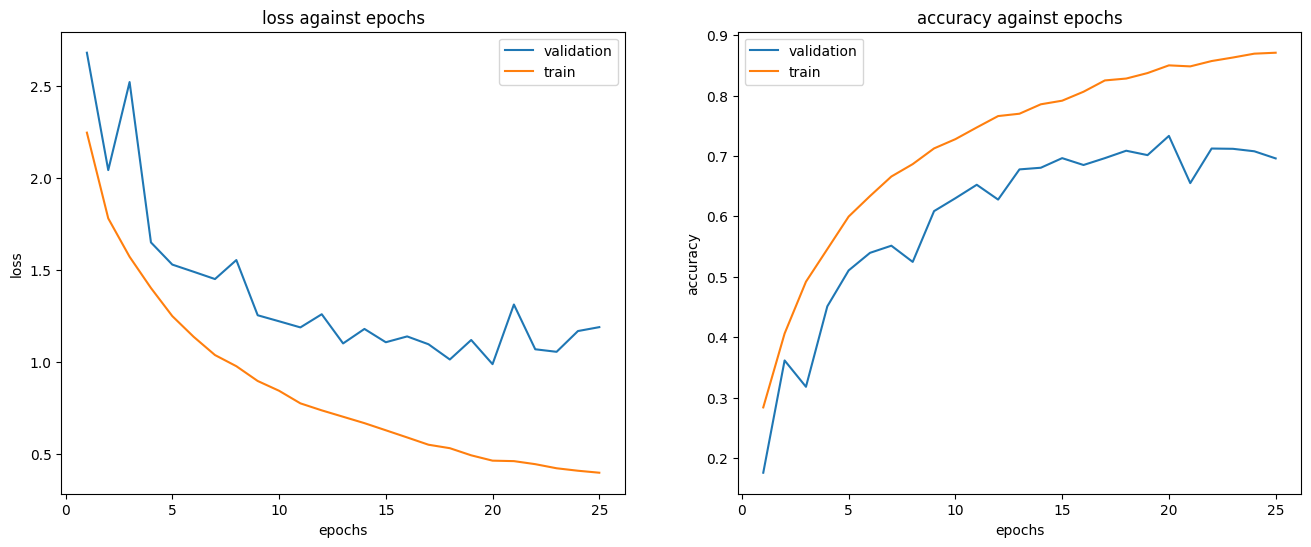

{'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.2, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


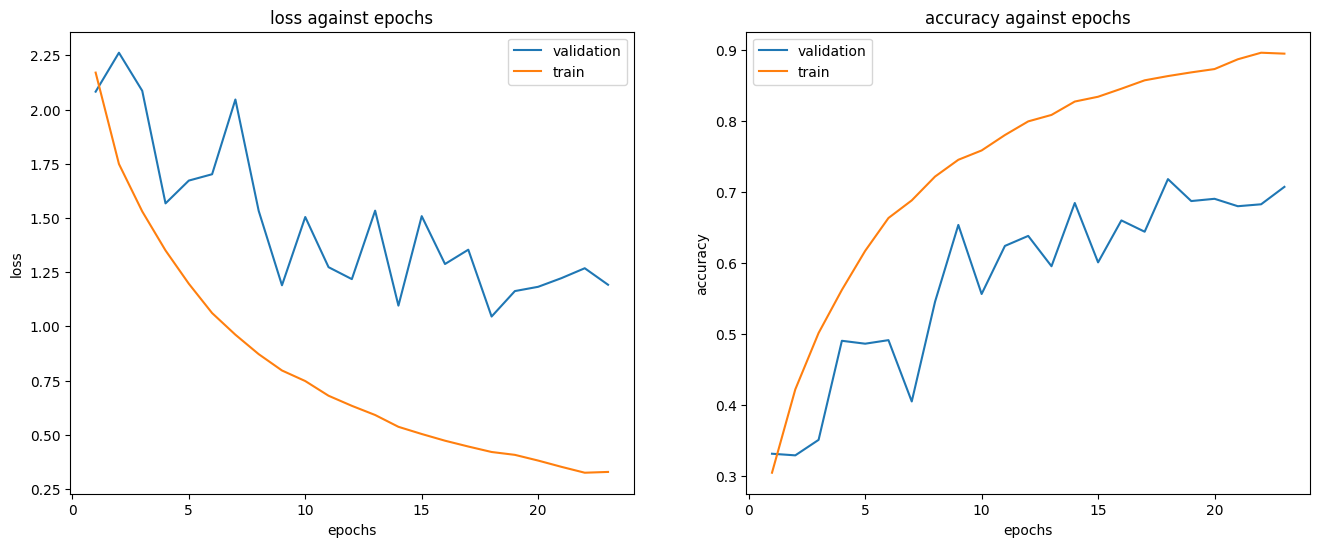

{'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.4, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


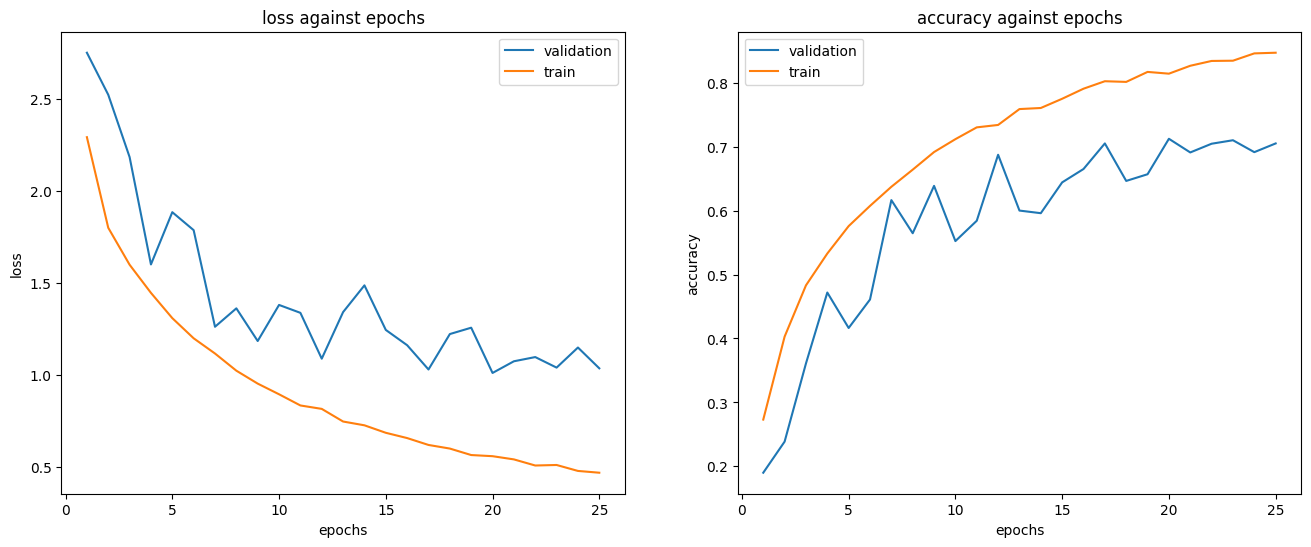

{'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.4, 'kernel_size': (3, 3), 'm': 1, 'max_neurons': 256, 'n': 3, 'padding': 'valid', 'strides': (1, 1)}


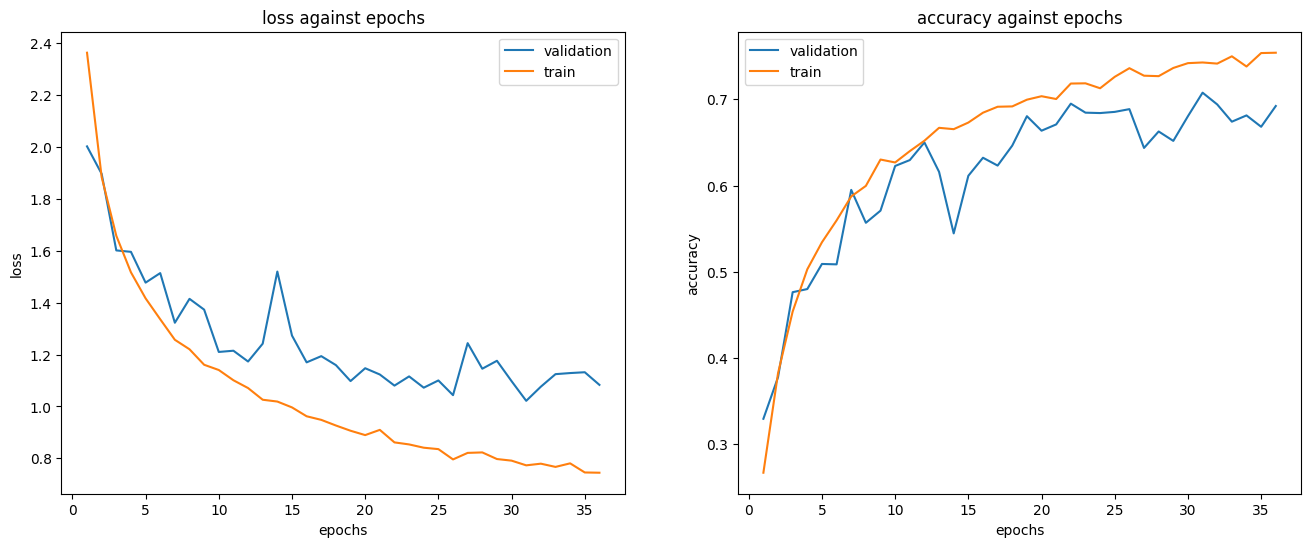

{'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.30000000000000004, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 64, 'n': 3, 'padding': 'same', 'strides': (1, 1)}


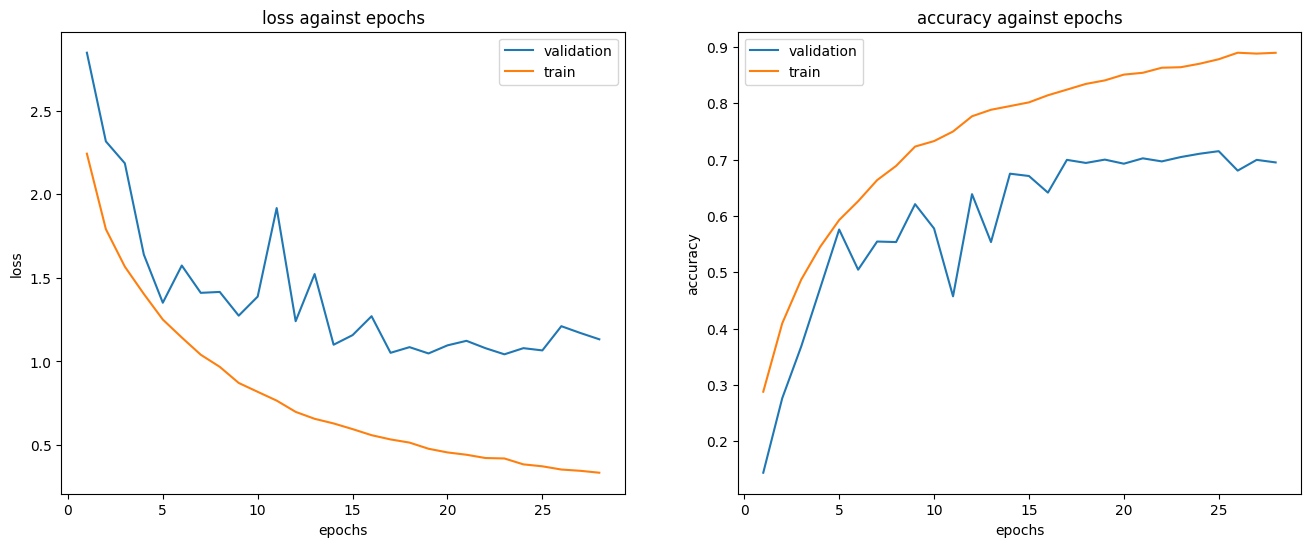

In [15]:
top_5_indexes = np.argsort(val_accuracies)[-5:][::-1]


for i in top_5_indexes:
  validation_loss = fit_results[i]['val_loss']
  validation_accuracy = fit_results[i]['val_accuracy']

  train_loss = fit_results[i]['loss']
  train_accuracy = fit_results[i]['accuracy']

  epochs = range(1 , len(validation_accuracy) + 1)

  fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6 ,))

  print(successful_params[i])

  # loss
  ax[0].plot(epochs , validation_loss, label='validation')
  ax[0].plot(epochs , train_loss, label='train')
  ax[0].legend()
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')
  ax[0].set_title('loss against epochs')

  # acc
  ax[1].plot(epochs , validation_accuracy, label='validation')
  ax[1].plot(epochs , train_accuracy, label='train')
  ax[1].legend()
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('accuracy against epochs')
  plt.show()


In [44]:
param_data_permu = []
param_data_permu_history = []
param_data_permu_loss = []
param_data_permu_accuracy = []

In [45]:
# Hyper tuning amount of data fed into the model
for i in top_5_indexes:
  params = successful_params[i]
  
  splits = [0.25 , 0.5 , 0.75 , 1]
  for split in splits:
    print(f'Traing {params}\n on {split} of data')
    if split != 1:
      X_train_split , _ ,y_train_split , _ = train_test_split(X_train , y_train, random_state=42 , train_size=split , stratify=y_train)
      X_train_split = np.asarray(X_train_split, dtype=np.float32)
      y_train_split = np.asarray(y_train_split, dtype=np.float32)
    else:
      X_train_split = np.asarray(X_train, dtype=np.float32)
      y_train_split = np.asarray(y_train, dtype=np.float32)

    X_validation = np.asarray(X_validation, dtype=np.float32)
    y_validation = np.asarray(y_validation, dtype=np.float32)


    # with different amounts of data epochs required might be different
    early_stop = EarlyStopping(monitor='val_loss' , patience=5 , restore_best_weights=True)
    model = create_model(**params)
    history = model.fit(
      X_train_split , y_train_split , 
      epochs=200, batch_size=16, 
      validation_data=(X_validation , y_validation),
      verbose = 0,
      callbacks=[early_stop]
      )

    # Eval and store
    val_loss , val_accuracy = model.evaluate(X_validation , y_validation)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation accuracy: {val_accuracy}')

    param_data_permu.append({
      **params, 
      'size': split
    })
    param_data_permu_history.append(history.history)
    param_data_permu_accuracy.append(val_accuracy)
    param_data_permu_loss.append(val_loss)

    # Plotting graph
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']

    epochs_range = range(1 , len(train_accuracy) + 1)


Traing {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.30000000000000004, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 128, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
 on 0.25 of data
69/69 [==============================] - 0s 5ms/step - loss: 1.9231 - accuracy: 0.3795
Validation Loss: 1.9230828285217285
Validation accuracy: 0.3795454502105713
Traing {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.30000000000000004, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 128, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
 on 0.5 of data
69/69 [==============================] - 0s 4ms/step - loss: 1.4666 - accuracy: 0.5755
Validation Loss: 1.4665833711624146
Validation accuracy: 0.5754545331001282
Traing {'activation

In [46]:
data_tune_results = pd.DataFrame({
 'permatation': param_data_permu,
 'history': param_data_permu_history,
 'validation_loss': param_data_permu_loss,
 'validation_accuracy': param_data_permu_accuracy
})

with open(os.path.join('tuning_results' , '23_data_tuning_v2.pkl') , 'wb') as f:
  pickle.dump(data_tune_results , f)

In [47]:
# Importing the results
results = None

with open(os.path.join('tuning_results' , '23_data_tuning_v2.pkl') , 'rb') as f:
  results = pickle.load(f)


In [58]:
# Here we can decide on what is the best set of params and partition of data
best_index = np.argmax(param_data_permu_accuracy)
size = param_data_permu[best_index]['size']
print(f'Best params: {param_data_permu[best_index]}')
print(f'Best size: {size}')
print(f'Val Loss: {param_data_permu_loss[best_index]}')
print(f'Val accuracy: {param_data_permu_accuracy[best_index]}')

Best params: {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.4, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'strides': (1, 1), 'size': 1}
Best size: 1
Val Loss: 1.0258041620254517
Val accuracy: 0.7040908932685852


##### Making Predictions

The results suggests that using all the training data is optimal for this problem

Though this result is different from the **'best'** result from my hyperparameter tuning phase

Therefore i can try to fit both and decide on the best model from there

In [63]:
params_to_consider = [
    best_params,
    {key:value for key , value in param_data_permu[best_index].items() if key != 'size'}
]

Testing {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.30000000000000004, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 128, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
69/69 [==============================] - 0s 4ms/step


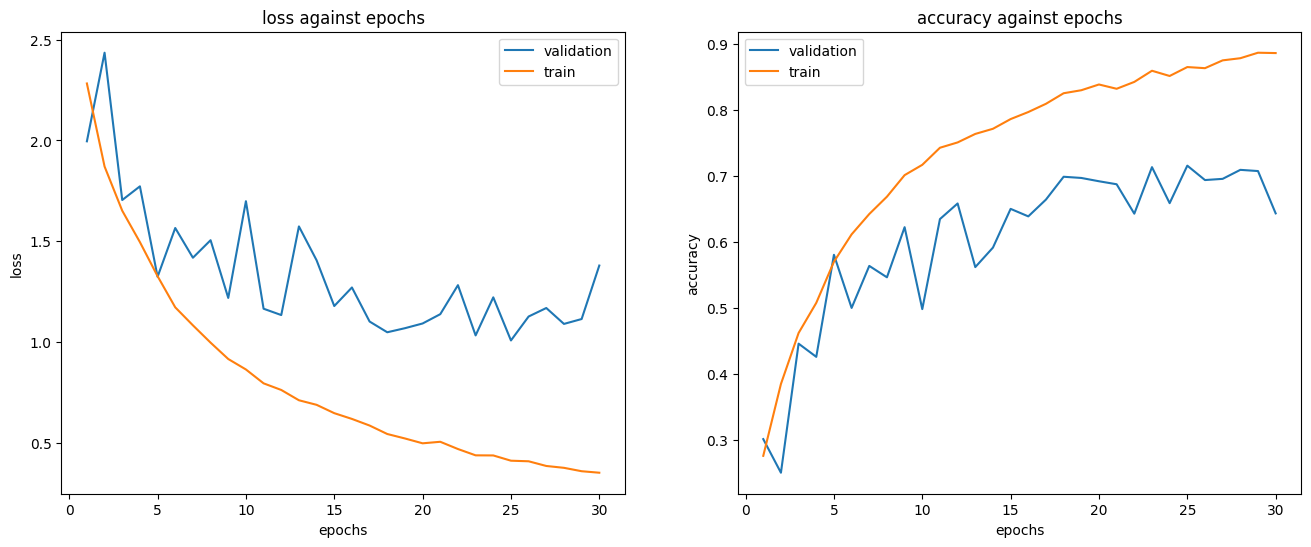

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       200
           1       0.82      0.75      0.78       200
           2       0.03      0.04      0.03       200
           3       0.02      0.01      0.02       200
           4       0.01      0.01      0.01       200
           5       0.14      0.12      0.13       200
           6       0.01      0.01      0.01       200
           7       0.03      0.02      0.02       200
           8       0.01      0.01      0.01       200
           9       0.03      0.03      0.03       200
          10       0.02      0.04      0.03       200

    accuracy                           0.17      2200
   macro avg       0.16      0.17      0.16      2200
weighted avg       0.16      0.17      0.16      2200



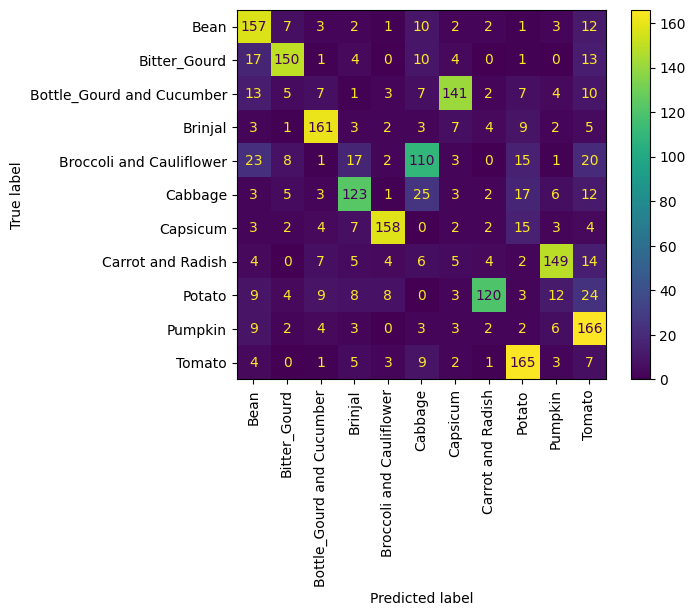

Testing {'activation': <keras.layers.activation.relu.ReLU object at 0x000001D5CB9C55E0>, 'bottleneck': <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6F5F16130>, 'dropout': 0.4, 'kernel_size': (5, 5), 'm': 1, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'strides': (1, 1)}
69/69 [==============================] - 0s 4ms/step


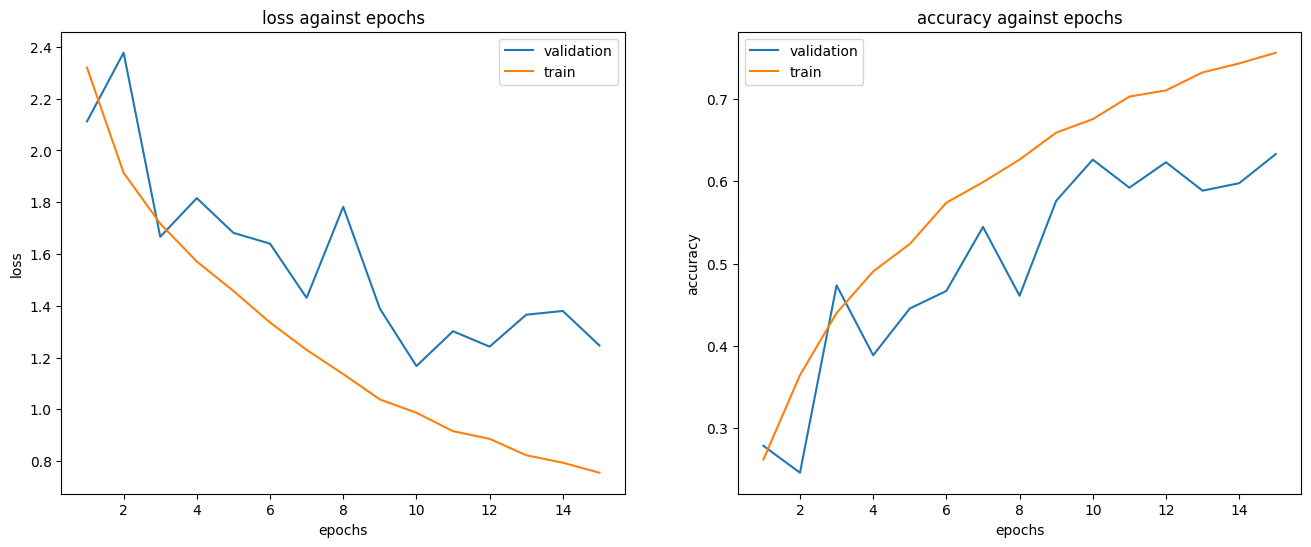

              precision    recall  f1-score   support

           0       0.65      0.58      0.62       200
           1       0.82      0.69      0.75       200
           2       0.02      0.02      0.02       200
           3       0.05      0.09      0.06       200
           4       0.01      0.01      0.01       200
           5       0.03      0.04      0.03       200
           6       0.00      0.00      0.00       200
           7       0.08      0.09      0.09       200
           8       0.01      0.01      0.01       200
           9       0.03      0.03      0.03       200
          10       0.02      0.02      0.02       200

    accuracy                           0.14      2200
   macro avg       0.16      0.14      0.15      2200
weighted avg       0.16      0.14      0.15      2200



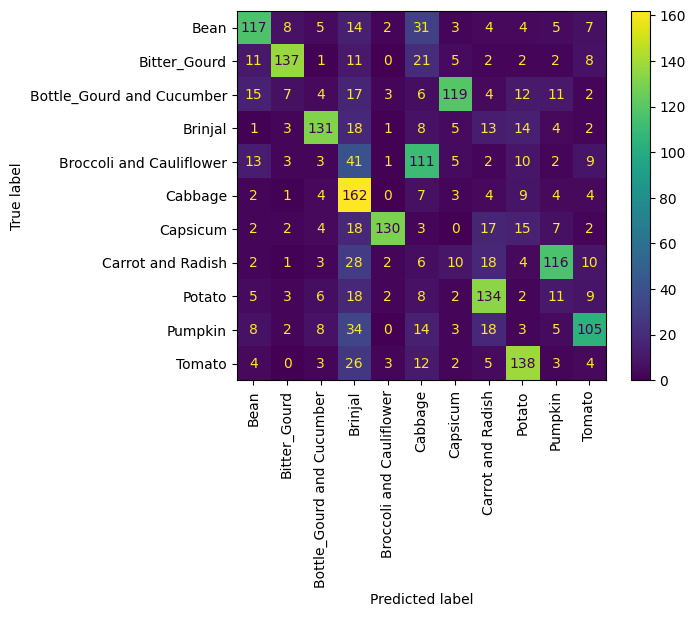

In [78]:
for i , params in enumerate(params_to_consider):
  print(f'Testing {params}')
  # callbacks
  early_stopper = EarlyStopping(patience=5 , monitor='val_loss', restore_best_weights=True)
  model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_params_set{i}.h5'),
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weight_only=True,                                    
                                      mode='min'
                                     )
  # fitting
  model = create_model(**params)
  results = model.fit(X_train , y_train , 
                      epochs=200,
                      validation_data=(X_validation , y_validation),
                      callbacks=[early_stopper , model_checkpoint],
                      verbose=0
                      )
  epochs = len(results.history['loss'])
  # predict
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

  # Plots
  validation_loss = results.history['val_loss']
  validation_accuracy = results.history['val_accuracy']
  
  train_loss = results.history['loss']
  train_accuracy = results.history['accuracy']
  
  epochs = range(1 , len(train_loss) + 1)

  fig , ax = plt.subplots(1 ,2 , figsize=(16 , 6))

  # loss
  ax[0].plot(epochs , validation_loss, label='validation')
  ax[0].plot(epochs , train_loss, label='train')
  ax[0].legend()
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')
  ax[0].set_title('loss against epochs')

  # acc
  ax[1].plot(epochs , validation_accuracy, label='validation')
  ax[1].plot(epochs , train_accuracy, label='train')
  ax[1].legend()
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('accuracy against epochs')
  plt.show()

  ## results
  print(classification_report(y_test , y_pred))
  cm = confusion_matrix(y_test , y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.columns[1:])
  disp.plot()
  plt.xticks(rotation=90)
  plt.show()

### 101 x 101

Now i can do the exact same steps for 101x101 size